In [1]:
import json
import numpy as np
from datasets import load_dataset
from transformers import AutoTokenizer

import matplotlib.pyplot as plt
from utils.input_utils import llama_dialog_preprocess, map_dialog_to_tokenizer_input, map_data_to_lambda_text

/Users/id4thomas/miniforge3/envs/torch2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Put your huggingface api key here
with open("auth_tokens.json", "r") as f:
	AUTH_TOKEN = json.loads(f.read())["hf_token"]

In [3]:
tokenizer = AutoTokenizer.from_pretrained(
	"meta-llama/Llama-2-7b-chat-hf",
	use_auth_token = AUTH_TOKEN
)

/Users/id4thomas/miniforge3/envs/torch2/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1714: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [4]:
data = load_dataset("beomi/KoAlpaca-v1.1a")

Found cached dataset parquet (/Users/id4thomas/.cache/huggingface/datasets/beomi___parquet/beomi--KoAlpaca-v1.1a-1465f66eb846fd61/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 143.10it/s]


In [5]:
print(data)

DatasetDict({
    train: Dataset({
        features: ['instruction', 'output', 'url'],
        num_rows: 21155
    })
})


In [6]:
inst_text_lens = np.array([len(inst) for inst in data["train"]["instruction"]])
inst_token_lens = [tokenizer(inst, return_tensors="pt")["input_ids"].shape[-1] for inst in data["train"]["instruction"]]

In [7]:
print("Instruction text lens")
print("Min: {}, Max: {}, Avg: {}".format(min(inst_text_lens), max(inst_text_lens), sum(inst_text_lens)/len(inst_text_lens)))

print("Instruction token lens")
print("Min: {}, Max: {}, Avg: {}".format(min(inst_token_lens), max(inst_token_lens), sum(inst_token_lens)/len(inst_token_lens)))

Instruction text lens
Min: 9, Max: 711, Avg: 69.94937367052707
Instruction token lens
Min: 11, Max: 953, Avg: 107.45218624438667


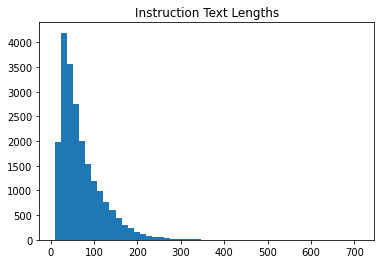

In [8]:
plt.hist(inst_text_lens, bins = 50)
plt.title("Instruction Text Lengths")
plt.show()

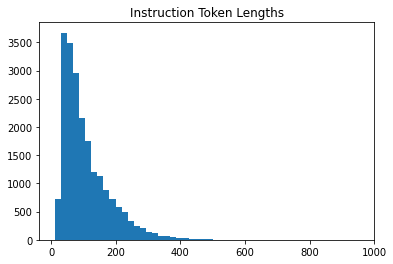

In [9]:
plt.hist(inst_token_lens, bins = 50)
plt.title("Instruction Token Lengths")
plt.show()

In [10]:
out_text_lens = np.array([len(output) for output in data["train"]["output"]])
out_token_lens = [tokenizer(output, return_tensors="pt")["input_ids"].shape[-1] for output in data["train"]["output"]]

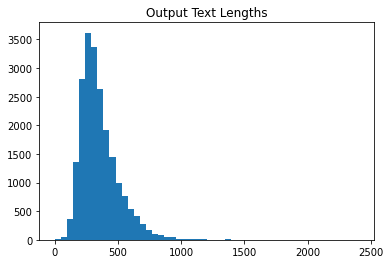

In [11]:
plt.hist(out_text_lens, bins = 50)
plt.title("Output Text Lengths")
plt.show()

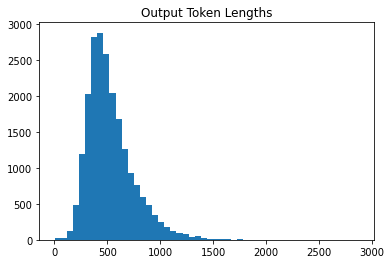

In [12]:
plt.hist(out_token_lens, bins = 50)
plt.title("Output Token Lengths")
plt.show()

In [13]:
# Instruction completed length check
data = data.map(
    lambda x: {'text': tokenizer.bos_token+map_data_to_lambda_text(x)+tokenizer.eos_token}
)

Loading cached processed dataset at /Users/id4thomas/.cache/huggingface/datasets/beomi___parquet/beomi--KoAlpaca-v1.1a-1465f66eb846fd61/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-3e555cc3aa60eec8.arrow


In [14]:
full_text_lens = np.array([len(fulltext) for fulltext in data["train"]["text"]])
full_token_lens = [tokenizer(fulltext, return_tensors="pt")["input_ids"].shape[-1] for fulltext in data["train"]["text"]]

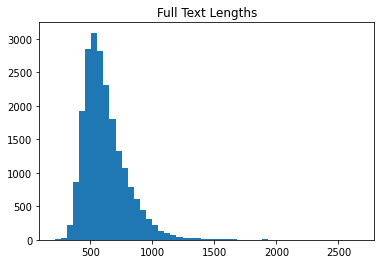

In [15]:
plt.hist(full_text_lens, bins = 50)
plt.title("Full Text Lengths")
plt.show()

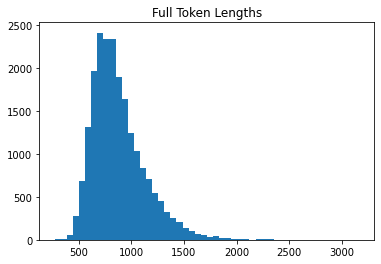

In [16]:
plt.hist(full_token_lens, bins = 50)
plt.title("Full Token Lengths")
plt.show()

In [17]:
def get_pct_below_threshold(lens, threshold):
	lens = np.array(lens)
	len_below = lens[lens<threshold]
	pct = len_below.shape[0]/lens.shape[0]
	return pct

# Token Length based
length_threshold = 1024
pct_1024 = get_pct_below_threshold(full_token_lens, 1024)
print("<1024: {:.3f}".format(pct_1024))

pct_2048 = get_pct_below_threshold(full_token_lens, 2048)
print("<2048: {:.3f}".format(pct_2048))

<1024: 0.766
<2048: 0.998


In [21]:
def get_below_threshold_idxs(lens, threshold):
	lens = np.array(lens)
	return np.where(lens<threshold)[0]

selected_indicies = get_below_threshold_idxs(full_token_lens, 1024)
print(len(selected_indicies), len(full_token_lens))
data["selected"] = data["train"][selected_indicies]

16211 21155


In [19]:
print(len(data["selected"]["text"]))

16211
